In [66]:
#! conda install -y -c conda-forge biopython
#! pip install nglview
#########################################

## check sequences' structure:
#### alphabet
#### pattern
#### codons frequency


### visualizzazione e analisi aminoacidi - proteine

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for nglview: filename=nglview-3.0.3-py3-none-any.whl size=8057560 sha256=77639830fa1776101bc5d029251bd4bdf65ae0448418a0a439037c2113741c5c
  Stored in directory: c:\users\samue\appdata\local\pip\cache\wheels\ed\12\ba\4e227d89934c5d7bdf91387286e45dc868613ab32fa6ce36cf
Successfully built nglview


In [343]:
import Bio as bio
import Bio.SeqIO as SeqIO 
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from Bio.PDB import *
import nglview as nv
import ipywidgets

from Bio import AlignIO
from Bio import Align
from Bio.Align import MultipleSeqAlignment

from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

import networkx as nx

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re



plt.style.use('seaborn')

In [37]:
# FASTA: seq, id, name, description, 

fasta_records = SeqIO.parse('ests.fa', 'fasta')

records_list = list(fasta_records)

print("Number of sequences in Fasta File", len(records_list))

Number of sequences in Fasta File 242


In [93]:
CDS_REGEX = '/cds=p\((\d+),(\d+)\)'

for record in records_list:
    desc = record.description 
    if '/cds=' in desc:
        result = re.search(CDS_REGEX, desc)
    
        print(result.group(1), result.group(2))

59 3019
59 2899
1 2830
53 2824
59 3019
43 2883
1 1073


In [315]:

# /gb=BG236814
GENBANK_ID_REGEX = '/gb=\w+\d+'
CDS_REGEX = '/cds=p\((\d+),(\d+)\)'

cds_list = []
protein_list = []
no_cds_list = []
cds_list_malformed = []

for record in records_list:
    desc = record.description   
    
    result = re.search(GENBANK_ID_REGEX, desc)
    
    if x == None:
        raise Exception(f"No GenbankId found in {record.description}")
    
    gb= result.group(0)
    

    seq = record.seq
    
    if '/cds=' in desc:
        print(gb)
        
        result_cds = re.search(CDS_REGEX, desc)
        start = int(result_cds.group(1)) -1
        end = int(result_cds.group(2))
        
        seq = seq[start: end]
        
        print(seq[0:3])
        print(seq[-3:])
        
        seq_len = len(seq)
        
        if not seq_len%3 == 0:
            if 'partial cds' in desc:
                print(f"WARNING: CDS of {gb} is a partial cds, it will be skipped.")
                print(f"len: {seq_len}, start: {start}, end: {end}")
                continue
            else:
                raise Exception("CDS malformed: not multiple of three. len: {seq_len}, start: {start}, end: {end}")
        
        cds_list.append(SeqRecord(seq,
                               id=gb))
        
        protein_record = SeqRecord(seq.transcribe().translate(to_stop=True),
                               id=gb,
                               description="")
        
        protein_list.append(protein_record)
    else:
        if 'clone_end=5' in desc:
            seq = seq.reverse_complement()
            
        seq_record = SeqRecord(seq,
                       id=gb,
                       description="")
        
        no_cds_list.append(seq_record)
        

SeqIO.write(protein_list, "protein.fasta", "fasta")
SeqIO.write(no_cds_list, "no_cds_list.fasta", "fasta")

/gb=BC052303
ATG
TGA
/gb=NM_001666
ATG
TGA
/gb=D50921
CGG
TGA
len: 2830, start: 0, end: 2830
/gb=AK294562
ATG
TGA
/gb=NM_001164741
ATG
TGA
/gb=X78817
ATG
TGA
/gb=BC023626
CCC
TGA
len: 1073, start: 0, end: 1073


235

## Count amino acids

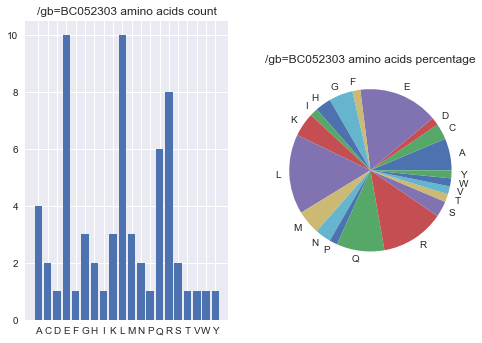

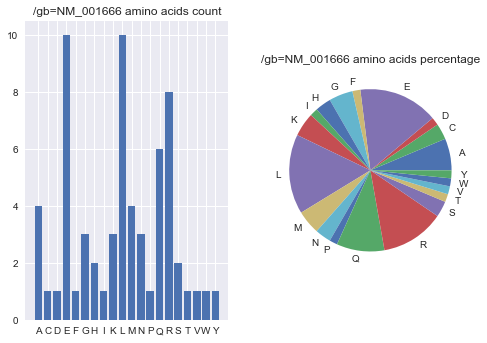

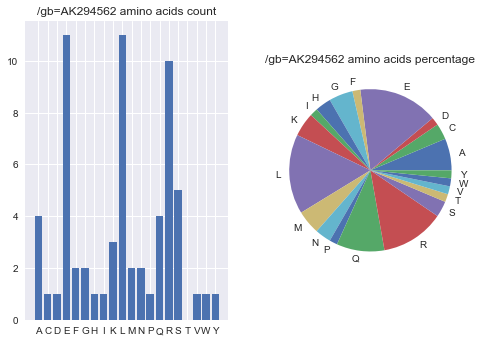

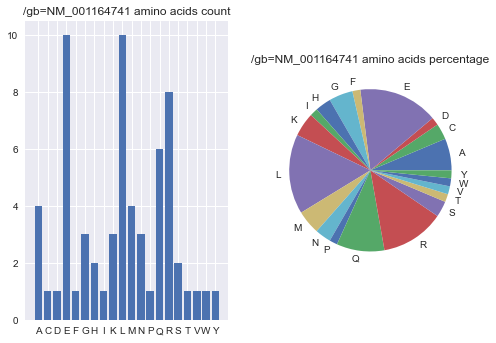

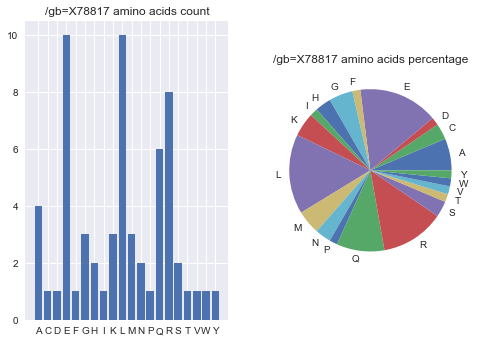

In [234]:
def aa_count_and_plot(protein):

    analyzed_seq = ProteinAnalysis(str(protein))


    k = analyzed_seq.count_amino_acids().keys()
    v = analyzed_seq.count_amino_acids().values()
    plt.subplot(1, 2, 1 )
    plt.bar(k, v )
    plt.title(f"{protein.id} amino acids count")
    
    plt.subplot(1, 2, 2)
    s = sum([v for v in list(v1)])

    v2 = [v/s*100 for v in list(v1)]

    plt.pie( v2, labels=k1)
    plt.title(f"{protein.id} amino acids percentage")

    
    plt.show()
    

for protein in protein_list:
    aa_count_and_plot(protein)

In [187]:
{protein.id: ProteinAnalysis(str(protein.seq)).molecular_weight() \
               for protein in protein_list}.keys()

dict_keys(['/gb=BC052303', '/gb=NM_001666', '/gb=AK294562', '/gb=NM_001164741', '/gb=X78817'])

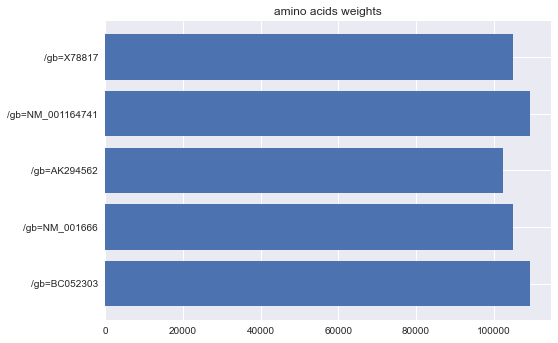

In [361]:
def compare_protein_weight(protein_list):
    weights = {protein.id: ProteinAnalysis(str(protein.seq)).molecular_weight() \
               for protein in protein_list}
        
    plt.barh(list(weights.keys()), list(weights.values()) )
    
    plt.title(f"amino acids weights")
    #plt.show()    

    
compare_protein_weight(protein_list)

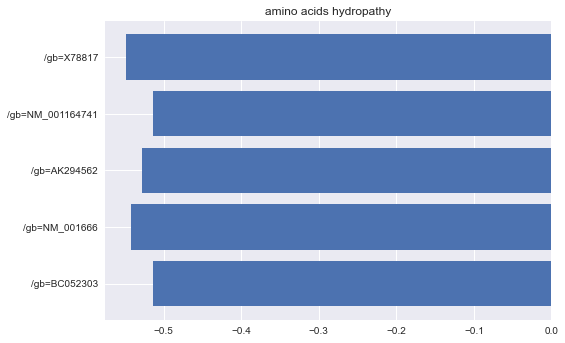

In [360]:
'''
The larger the number is, the more hydrophobic the amino acid. 
The most hydrophobic amino acids are isoleucine (4.5) and valine (4.2). 
The most hydrophilic ones are arginine (-4.5) --> R and lysine --> L (-3.9)

GRAVY value is calculated by adding the hydropathy value for each residue and dividing by the length of the sequence
'''

def compare_protein_gravy(protein_list):
    gravy = {protein.id: ProteinAnalysis(str(protein.seq)).gravy() \
               for protein in protein_list}
        
    plt.barh(list(gravy.keys()), list(gravy.values()) )
    
    plt.title(f"amino acids hydropathy")
    #plt.show()    

    
compare_protein_gravy(protein_list)

In [235]:
protein = protein_list[0]

{protein.id: ProteinAnalysis(str(protein.seq)).secondary_structure_fraction() \
               for protein in protein_list}

{'/gb=BC052303': (0.2565922920892495, 0.23630831643002032, 0.3154158215010142),
 '/gb=NM_001666': (0.2558139534883721, 0.233615221987315, 0.3181818181818182),
 '/gb=AK294562': (0.25677139761646806,
  0.23835319609967498,
  0.31527627302275185),
 '/gb=NM_001164741': (0.2565922920892495,
  0.23630831643002032,
  0.3154158215010142),
 '/gb=X78817': (0.2558139534883721, 0.233615221987315, 0.31606765327695563)}

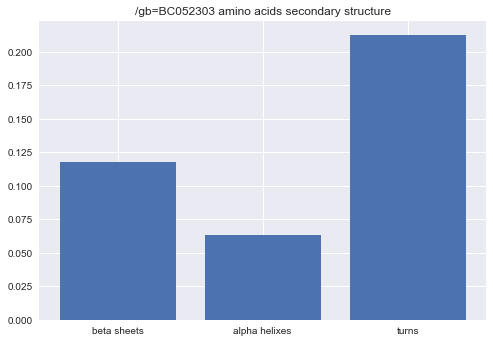

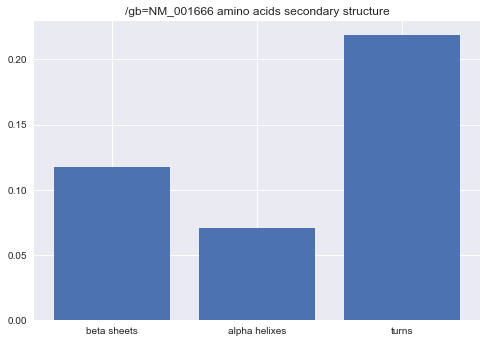

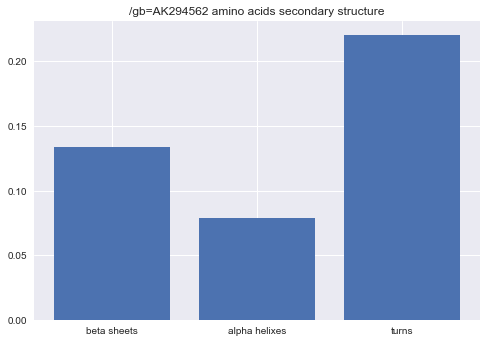

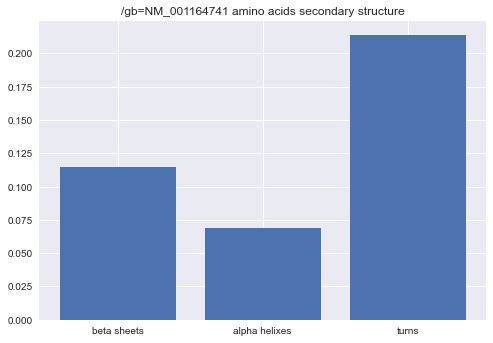

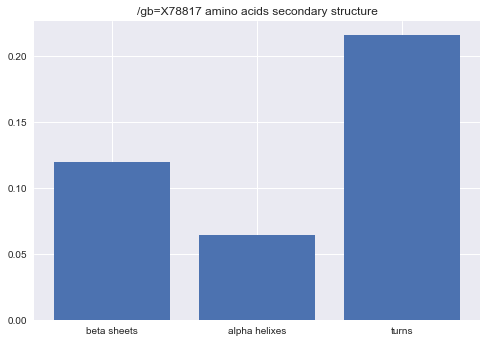

In [245]:
# .secondary_structure_fraction()

'''
 .secondary_structure_fraction() — returns the fraction of amino acids that tend to be found 
 in the three classical secondary structures. 
 These are beta sheets, alpha helixes, and turns (where the residues change direction).
'''

def compare_protein_secondary_structure(protein):
    analyzed_seq = ProteinAnalysis(str(protein))


    k = ["beta sheets", "alpha helixes", "turns"]
    v = analyzed_seq.secondary_structure_fraction()


    plt.bar( k, v)
    plt.title(f"{protein.id} amino acids secondary structure")

    
    plt.show()


for protein in protein_list:
    compare_protein_secondary_structure(protein)

In [79]:
# UGA --> Stop Codon (*)

Seq('*')

In [ ]:
for

In [260]:
from Bio.Align import substitution_matrices

aligner = Align.PairwiseAligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")

alignments = aligner.align("GAACT", "GAT")

print(len(alignments))
alignments[1].score

2


15.0

### Get all possibles pairs of cds

In [269]:
cds_pairs = [(a, b) for idx, a in enumerate(cds_list) for b in cds_list[idx + 1:]]
cds_pairs

[(SeqRecord(seq=Seq('ATGGCCGCTCACGGGAAGCTGCGGCGGGAGCGGGGGCTGCAGGCTGAGTATGAG...TGA'), id='/gb=BC052303', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
  SeqRecord(seq=Seq('ATGGCCGCTCACGGGAAGCTGCGGCGGGAGCGGGGGCTGCAGGCTGAGTATGAG...TGA'), id='/gb=NM_001666', name='<unknown name>', description='<unknown description>', dbxrefs=[])),
 (SeqRecord(seq=Seq('ATGGCCGCTCACGGGAAGCTGCGGCGGGAGCGGGGGCTGCAGGCTGAGTATGAG...TGA'), id='/gb=BC052303', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
  SeqRecord(seq=Seq('ATGCGCTGGCAGCTGAGCGAGCAGCTGCGCTGCCTGGAGCTGCAGGGCGAGCTG...TGA'), id='/gb=AK294562', name='<unknown name>', description='<unknown description>', dbxrefs=[])),
 (SeqRecord(seq=Seq('ATGGCCGCTCACGGGAAGCTGCGGCGGGAGCGGGGGCTGCAGGCTGAGTATGAG...TGA'), id='/gb=BC052303', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
  SeqRecord(seq=Seq('ATGGCCGCTCACGGGAAGCTGCGGCGGGAGCGGGGGCTGCAGGCTGAGTATGAG...TGA'), id='/gb=NM_001164741', name

### Get BLOSUM62 Alignement Score

Computing BLOSUM62 score between /gb=BC052303 and /gb=NM_001666
18148.0
Computing BLOSUM62 score between /gb=BC052303 and /gb=AK294562
17733.0
Computing BLOSUM62 score between /gb=BC052303 and /gb=NM_001164741
18942.0
Computing BLOSUM62 score between /gb=BC052303 and /gb=X78817
18133.0
Computing BLOSUM62 score between /gb=NM_001666 and /gb=AK294562
17724.0
Computing BLOSUM62 score between /gb=NM_001666 and /gb=NM_001164741
18153.0
Computing BLOSUM62 score between /gb=NM_001666 and /gb=X78817
18138.0
Computing BLOSUM62 score between /gb=AK294562 and /gb=NM_001164741
17724.0
Computing BLOSUM62 score between /gb=AK294562 and /gb=X78817
17709.0
Computing BLOSUM62 score between /gb=NM_001164741 and /gb=X78817
18138.0


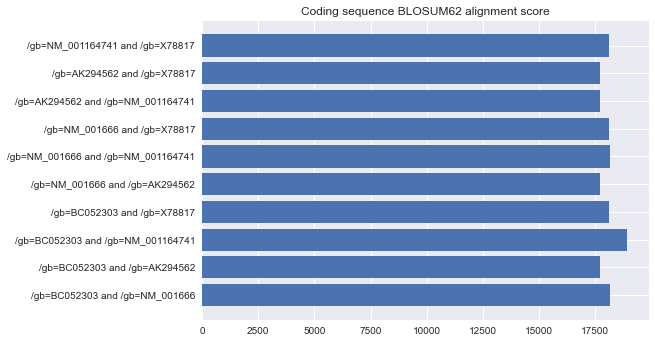

In [271]:
aligner = Align.PairwiseAligner()
aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")

result_id = []
result_score = []

for a, b in cds_pairs:
    label = f"{a.id} and {b.id}"
    result_id.append(label)
    print(f"Computing BLOSUM62 score between {label}")
    
    alignments = aligner.align(a.seq, b.seq)
    score = alignments[0].score
    
    result_score.append(score)
    print(score)
    

plt.barh(result_id, result_score)
plt.title(f"Coding sequence BLOSUM62 alignment score")

    
plt.show()

In [317]:
len(cds_list)

5

maxlen:  2961
/gb=BC052303	0
/gb=NM_001666	0.5535292131036812	0
/gb=AK294562	0.7115839243498818	0.6710570753123944	0
/gb=NM_001164741	0.00033772374197904576	0.5535292131036812	0.7119216480918609	0
/gb=X78817	0.5535292131036812	0.0006754474839580915	0.6710570753123944	0.5535292131036812	0
	/gb=BC052303	/gb=NM_001666	/gb=AK294562	/gb=NM_001164741	/gb=X78817
Tree(rooted=False)
    Clade(branch_length=0, name='Inner3')
        Clade(branch_length=0.25607902735562316, name='Inner2')
            Clade(branch_length=0.4146403242147923, name='/gb=AK294562')
            Clade(branch_length=0.2969436001350895, name='Inner1')
                Clade(branch_length=0.00022514916131932683, name='/gb=NM_001164741')
                Clade(branch_length=0.00011257458065971893, name='/gb=BC052303')
        Clade(branch_length=0.00033772374197904576, name='/gb=NM_001666')
        Clade(branch_length=0.00033772374197904576, name='/gb=X78817')


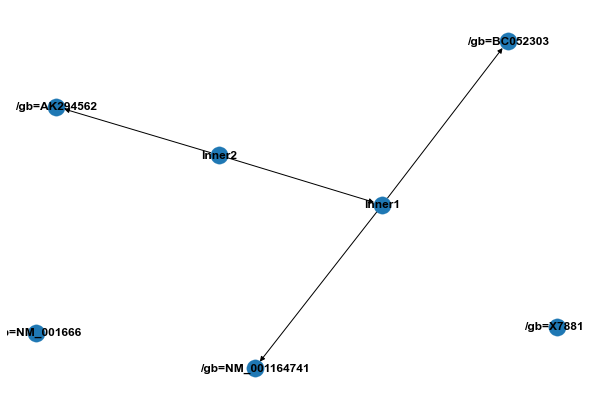

<Figure size 576x396 with 0 Axes>

In [359]:
maxlen = max(len(record.seq) for record in cds_list)
print("maxlen: ", maxlen)

pad_list = []

for record in cds_list:
    if len(record.seq) != maxlen:
        seq = Seq(str(record.seq).ljust(maxlen, '.'))
        pad_list.append(SeqRecord(seq, record.id))
        
    else:
        pad_list.append(SeqRecord(record.seq, record.id))
        
        
assert all(len(record.seq) == maxlen for record in pad_list)

align = MultipleSeqAlignment(pad_list)

calculator = DistanceCalculator('identity')
dm = calculator.get_distance(align)
print(dm)

constructor = DistanceTreeConstructor()
njtree = constructor.nj(dm)
print(njtree)

# find_elements(self, target=None, terminal=None, order='preorder', **kwargs)

#njtree.get_path('/gb=BC052303')

#for clade in njtree.get_nonterminals():
#    print(clade)

G = nx.DiGraph()




for record in cds_list:
    gb = record.id
    
    clade_list = njtree.get_path(gb)
    
    i = len(clade_list) -1
    child = None
    while i >= 0:
        clade = clade_list[i]
        if clade not in G.nodes:
            G.add_node(clade)
        if child != None:
            G.add_edge(clade, child)
        child = clade
        
        i -= 1
        
            
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

plt.savefig("graph.png")

maxlen:  2961
/gb=BC052303	0
/gb=NM_001666	0.5535292131036812	0
/gb=AK294562	0.7115839243498818	0.6710570753123944	0
/gb=NM_001164741	0.00033772374197904576	0.5535292131036812	0.7119216480918609	0
/gb=X78817	0.5535292131036812	0.0006754474839580915	0.6710570753123944	0.5535292131036812	0
	/gb=BC052303	/gb=NM_001666	/gb=AK294562	/gb=NM_001164741	/gb=X78817
Tree(rooted=True)
    Clade(branch_length=0, name='Inner4')
        Clade(branch_length=0.34570246538331645, name='/gb=AK294562')
        Clade(branch_length=0.3453647416413374, name='Inner3')
            Clade(branch_length=0.27642688280986155, name='Inner2')
                Clade(branch_length=0.00033772374197904576, name='/gb=X78817')
                Clade(branch_length=0.00033772374197904576, name='/gb=NM_001666')
            Clade(branch_length=0.2765957446808511, name='Inner1')
                Clade(branch_length=0.00016886187098952288, name='/gb=NM_001164741')
                Clade(branch_length=0.00016886187098952288, name='/g

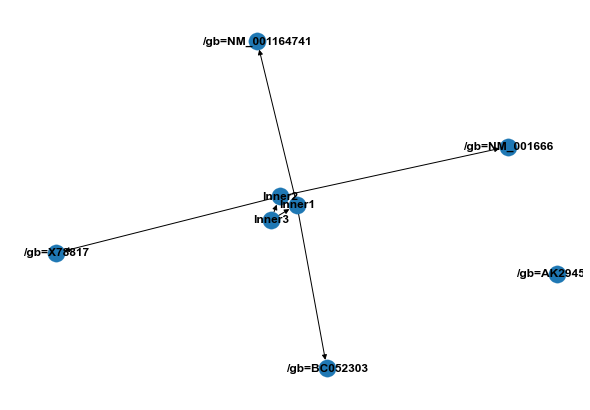

<Figure size 576x396 with 0 Axes>

In [362]:
maxlen = max(len(record.seq) for record in cds_list)
print("maxlen: ", maxlen)

pad_list = []

for record in cds_list:
    if len(record.seq) != maxlen:
        seq = Seq(str(record.seq).ljust(maxlen, '.'))
        pad_list.append(SeqRecord(seq, record.id))
        
    else:
        pad_list.append(SeqRecord(record.seq, record.id))
        
        
assert all(len(record.seq) == maxlen for record in pad_list)

align = MultipleSeqAlignment(pad_list)

calculator = DistanceCalculator('identity')
dm = calculator.get_distance(align)
print(dm)

constructor = DistanceTreeConstructor()
njtree = constructor.upgma(dm)
print(njtree)

# find_elements(self, target=None, terminal=None, order='preorder', **kwargs)

#njtree.get_path('/gb=BC052303')

#for clade in njtree.get_nonterminals():
#    print(clade)

G = nx.DiGraph()




for record in cds_list:
    gb = record.id
    
    clade_list = njtree.get_path(gb)
    
    i = len(clade_list) -1
    child = None
    while i >= 0:
        clade = clade_list[i]
        if clade not in G.nodes:
            G.add_node(clade)
        if child != None:
            G.add_edge(clade, child)
        child = clade
        
        i -= 1
        
            
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

plt.savefig("graph.png")